In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import skimage

from src.utils import get_bounding_box
from src.models import InputImage
from src.filters import yen_th, sobel
from skimage.morphology import disk, binary_closing, binary_opening, convex_hull_image

In [3]:
def refine_fish_convex_mask(input_img: InputImage) -> InputImage:
    bbox = input_img.fish_props.bounding_box
    remaining = np.zeros_like(input_img.fish_props.mask.masked)
    edges = sobel(input_img.fish_props.mask.masked[bbox.x1:bbox.x2, bbox.y1:bbox.y2])

    se = disk(2)
    x = binary_closing(binary_opening(yen_th(edges), se), se).astype(float)
    hull = convex_hull_image(x)

    remaining[bbox.x1:bbox.x2, bbox.y1:bbox.y2] = hull

    input_img.binary = remaining.copy()
    input_img.fish_props.mask.og = remaining.copy()
    input_img.fish_props.mask.masked = remaining * input_img.well_props.mask.cropped_masked
    input_img.fish_props.bounding_box = get_bounding_box(remaining)
    input_img.processed = remaining * input_img.well_props.mask.cropped_masked.copy()

    return input_img

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________
# Searching fish properties
_____________________________________________________________
# Creating fish convex mask
_____________________________________________________________
# Applying Yen-thresholding
_____________________________________________________________
# Stored binary image in object
_____________________________________________________________
# Getting convex hull for fish
_____________________________________________________________
# Stored fish mask & bounding box
_____________________________________________________________


Text(0.5, 1.0, 'Fish masked')

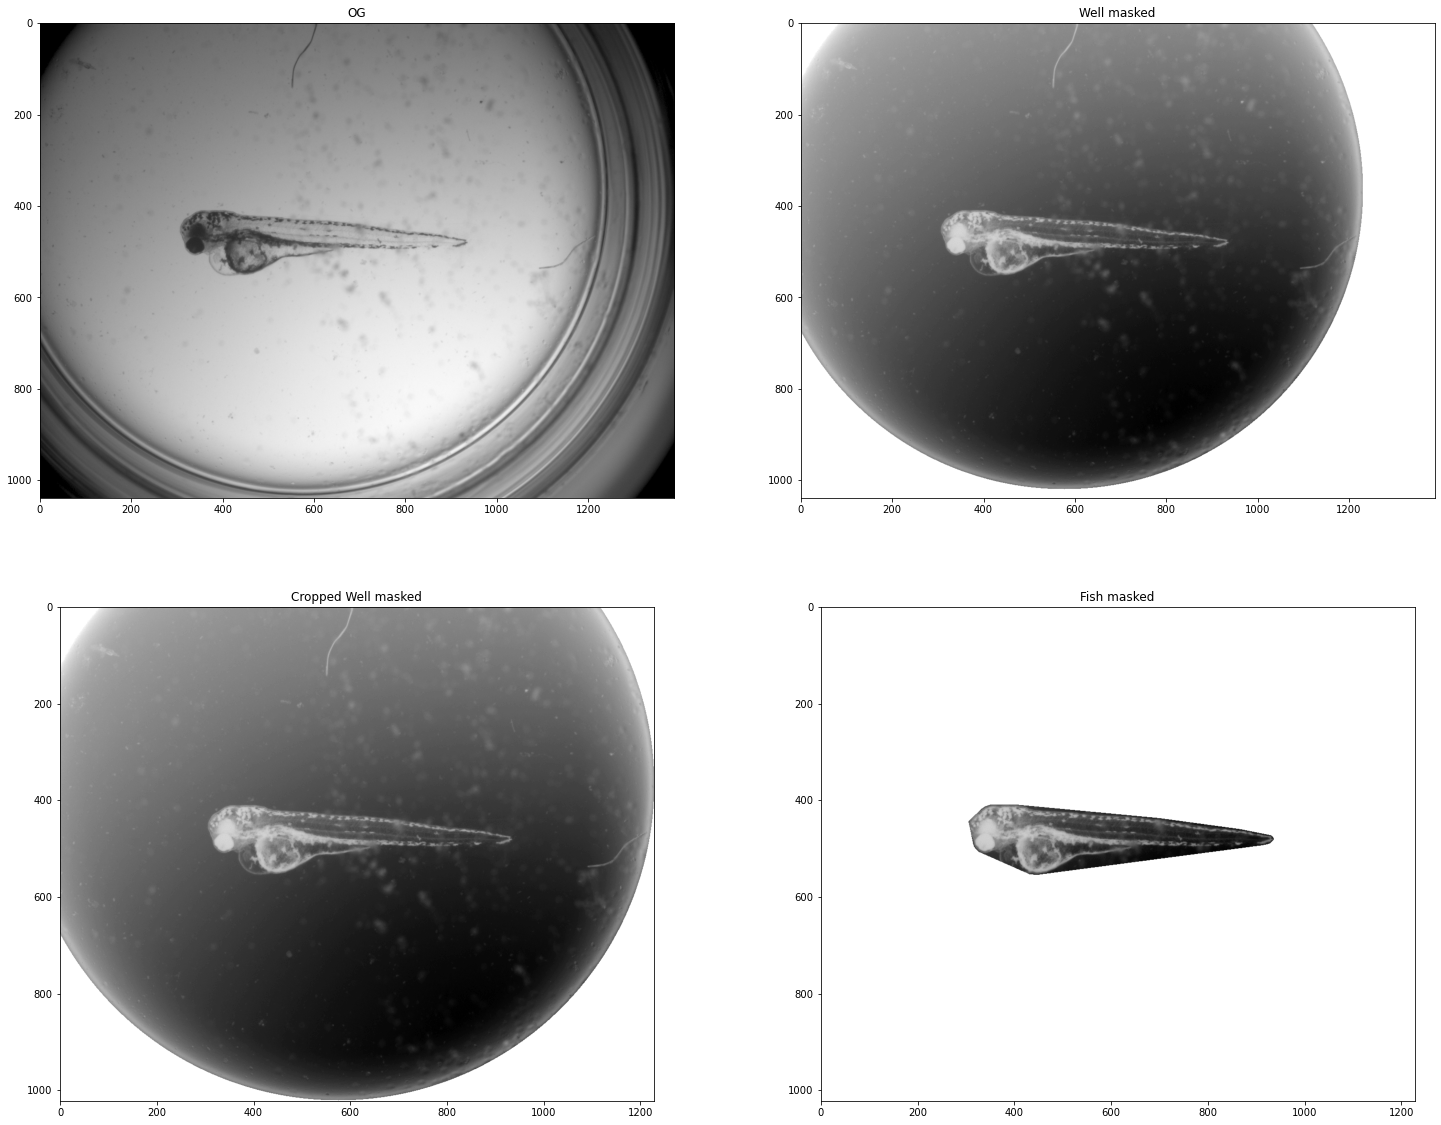

In [25]:
from src.fish.find_fish_props import find_fish_props
from src.well.find_well_props import find_well_props

fishy = InputImage("zf3.jpg")
fishy = find_well_props(fishy)
fishy = find_fish_props(fishy)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 20))
ax = ax.ravel()

ax[0].imshow(fishy.og, "binary")
ax[0].set_title('OG')
ax[1].imshow(fishy.well_props.mask.masked, "binary")
ax[1].set_title('Well masked')
ax[2].imshow(fishy.well_props.mask.cropped_masked, "binary")
ax[2].set_title('Cropped Well masked')
ax[3].imshow(fishy.fish_props.mask.masked, "binary")
ax[3].set_title('Fish masked')

Text(0.5, 1.0, 'W/O BG')

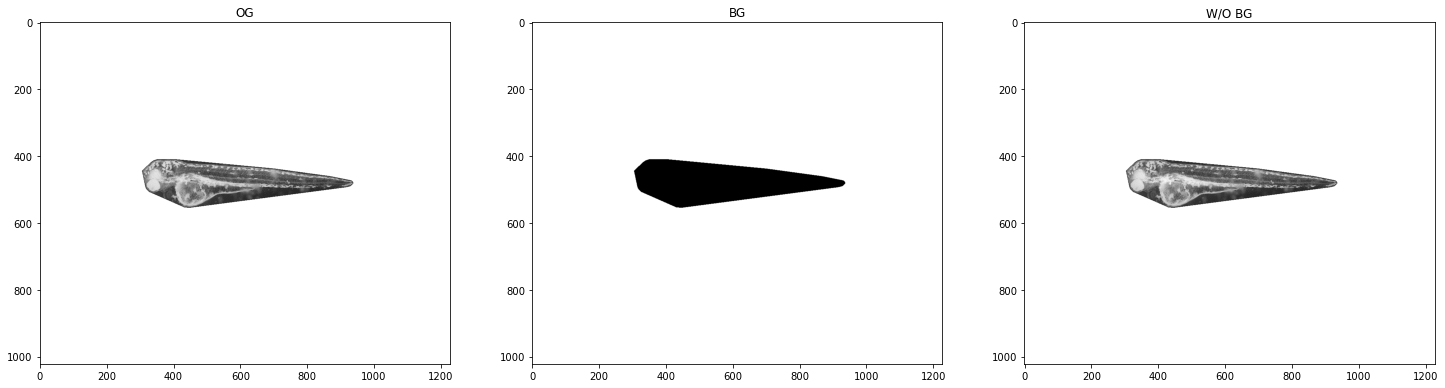

In [38]:
from src.filters import sharpen_img
from skimage.restoration import rolling_ball
from skimage.exposure import equalize_hist, equalize_adapthist

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 20))
ax = ax.ravel()

og = sharpen_img(fishy.fish_props.mask.masked)
bg = rolling_ball(og)
res = og - bg

res = equalize_adapthist(res)
og = equalize_adapthist(og)

ax[0].imshow(og, "binary")
ax[0].set_title('OG')
ax[2].imshow(res, "binary")
ax[1].imshow(yen_th(res), "binary")
ax[1].set_title('BG')
ax[2].set_title('W/O BG')


(1022, 1228)

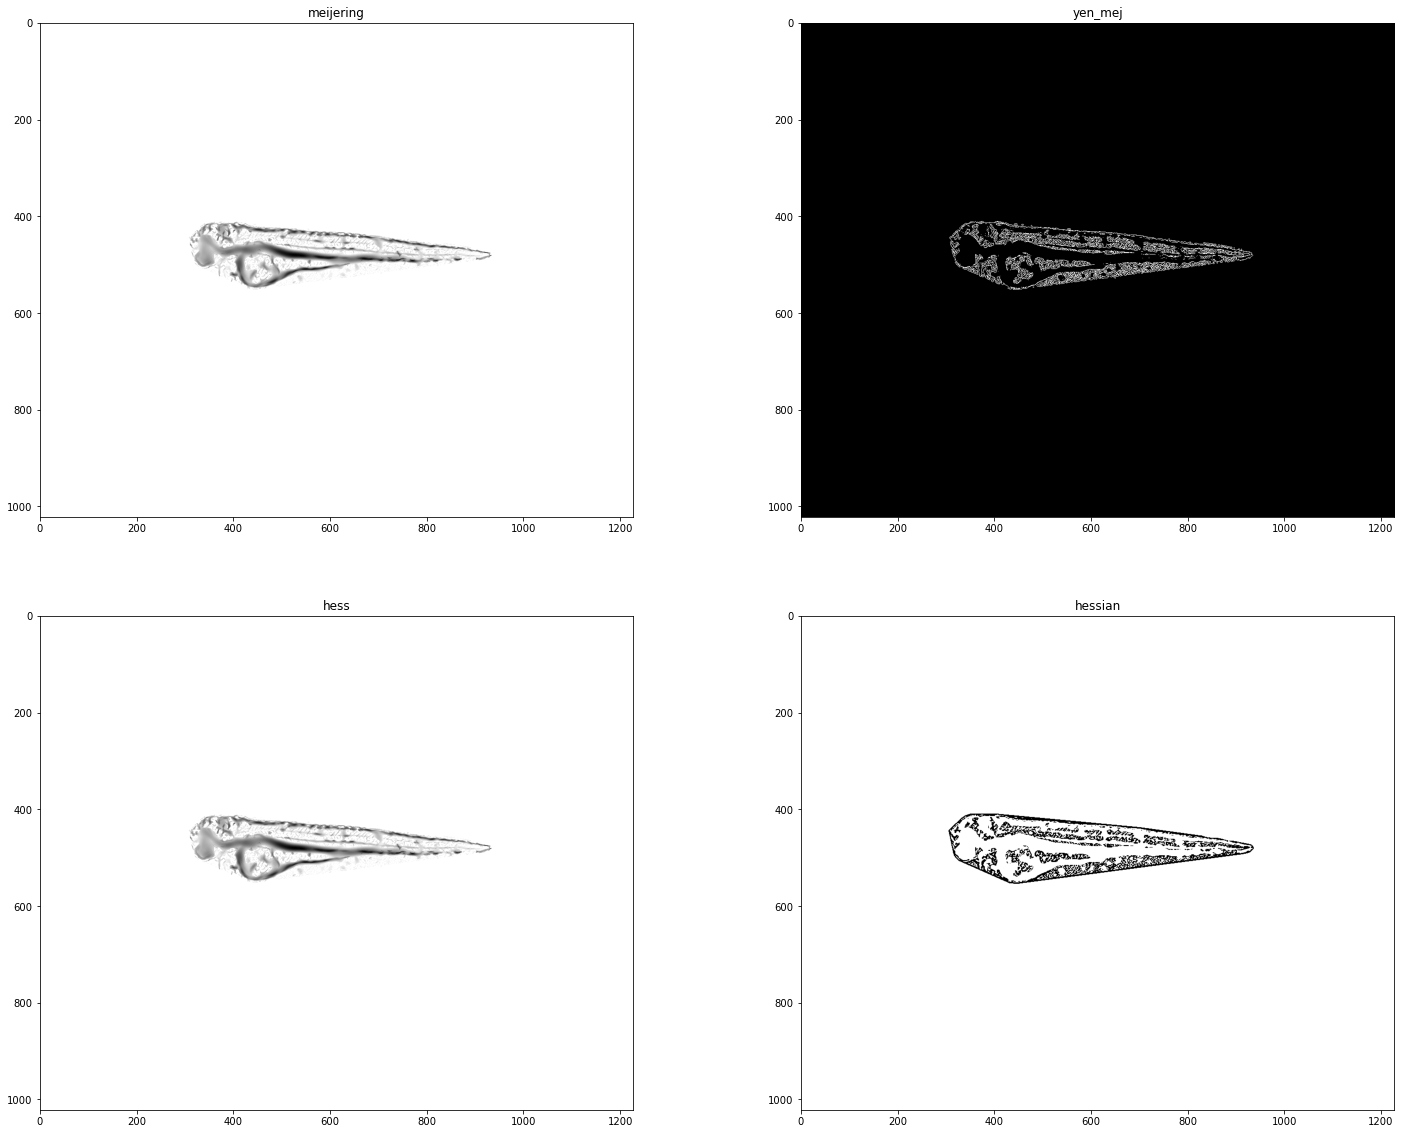

In [52]:
from skimage.filters.ridges import meijering, sato, frangi, hessian

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 20))
ax = ax.ravel()

mej = meijering(res) * fishy.fish_props.mask.og
# sat = sato(og) * fishy.fish_props.mask.og
# frang = frangi(og) * fishy.fish_props.mask.og
hess = hessian(res) * fishy.fish_props.mask.og

ax[0].imshow(mej, "binary")
ax[0].set_title('meijering')
ax[1].imshow(yen_th(sharpen_img(mej)), "binary")
ax[1].set_title('yen_mej')
ax[2].imshow(mej, "binary")
ax[2].set_title('hess')
ax[3].imshow(hess, "binary")
ax[3].set_title('hessian')

In [50]:
from skimage.exposure import rescale_intensity
from skimage.feature import hog

fd, hog_image = hog(res, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(res, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

ValueError: Only images with two spatial dimensions are supported. If using with color/multichannel images, specify `channel_axis`.